- Summarize the class distribution, the lengths of time series, and basic descriptive statistics

- Report any characteristics that could be used to deduce which class a time series belongs to

- Visualize ECG time series of the individual classes, and explain the differences between classes by utilizing the collected statistics

- Construct a validation split from your training data that reflects the characteristics of the full training data. In the report, justify your selection.

In [ ]:
import os
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

root_path = 'D:\\AMLS'
data_path = os.path.join(root_path, 'data')
train_data_path = os.path.join(data_path, 'X_train.bin')
test_data_path = os.path.join(data_path, 'X_test.bin')
train_label_path = os.path.join(data_path, 'y_train.csv')

In [2]:
def read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array

def read_binary_from(ragged_array, r):
    while(True):
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack('i', size_bytes)[0]
        sub_array = list(struct.unpack(f'{sub_array_size}h', r.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

In [3]:
signals = read_binary(train_data_path)
labels = pd.read_csv(train_label_path, header=None)
print(f"Total signals: {len(signals)}")
print(f"Total labels: {len(labels)}")
print(f"Shape of ECG data i.e., signal length can differ: {len(signals[0]), len(signals[6135]), len(signals[6178])}")

Total signals: 6179
Total labels: 6179
Shape of ECG data i.e., signal length can differ: (9000, 4444, 18000)


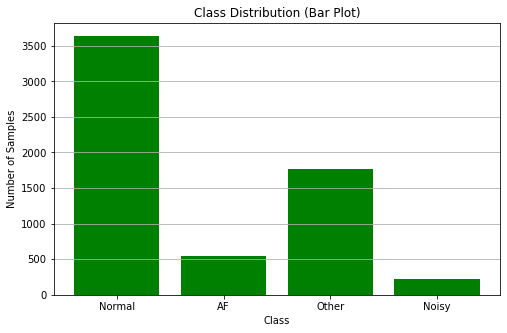

In [4]:
label_dict = {
    0: 'Normal',
    1: 'AF',
    2: 'Other',
    3: 'Noisy'
}

label_counts = {key: 0 for key in label_dict.keys()}
for i in range(len(labels)):
    label = labels.iloc[i, 0] 
    label_counts[label] += 1
    
classes = label_dict.values()
counts = label_counts.values()

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(classes, counts, color='green')
plt.title("Class Distribution (Bar Plot)")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.show()

In [5]:
lengths_by_class = {0: [], 1: [], 2: [], 3: []}
length_stats_by_class = {}

for signal, label in zip(signals, labels.iloc[:, 0]):
    lengths_by_class[label].append(len(signal))
    
for klass, lengths in lengths_by_class.items():
    length_stats_by_class[klass] = {
        'mean_length': np.mean(lengths),
        'std_length': np.std(lengths),
        'min_length': np.min(lengths),
        'max_length': np.max(lengths),
    }

for klass, stats in length_stats_by_class.items():
    print(f"{label_dict[klass]} signal length statistics:")
    for key, value in stats.items():
        print(f"{key}: {value}")
    print()

Normal signal length statistics:
mean_length: 9662.820780648708
std_length: 3019.667749980426
min_length: 2714
max_length: 18286

AF signal length statistics:
mean_length: 9510.863387978143
std_length: 3620.514364013169
min_length: 2996
max_length: 18062

Other signal length statistics:
mean_length: 10366.379603399433
std_length: 3572.7746844695157
min_length: 2738
max_length: 18188

Noisy signal length statistics:
mean_length: 7210.215859030837
std_length: 2877.182774089859
min_length: 2808
max_length: 18000



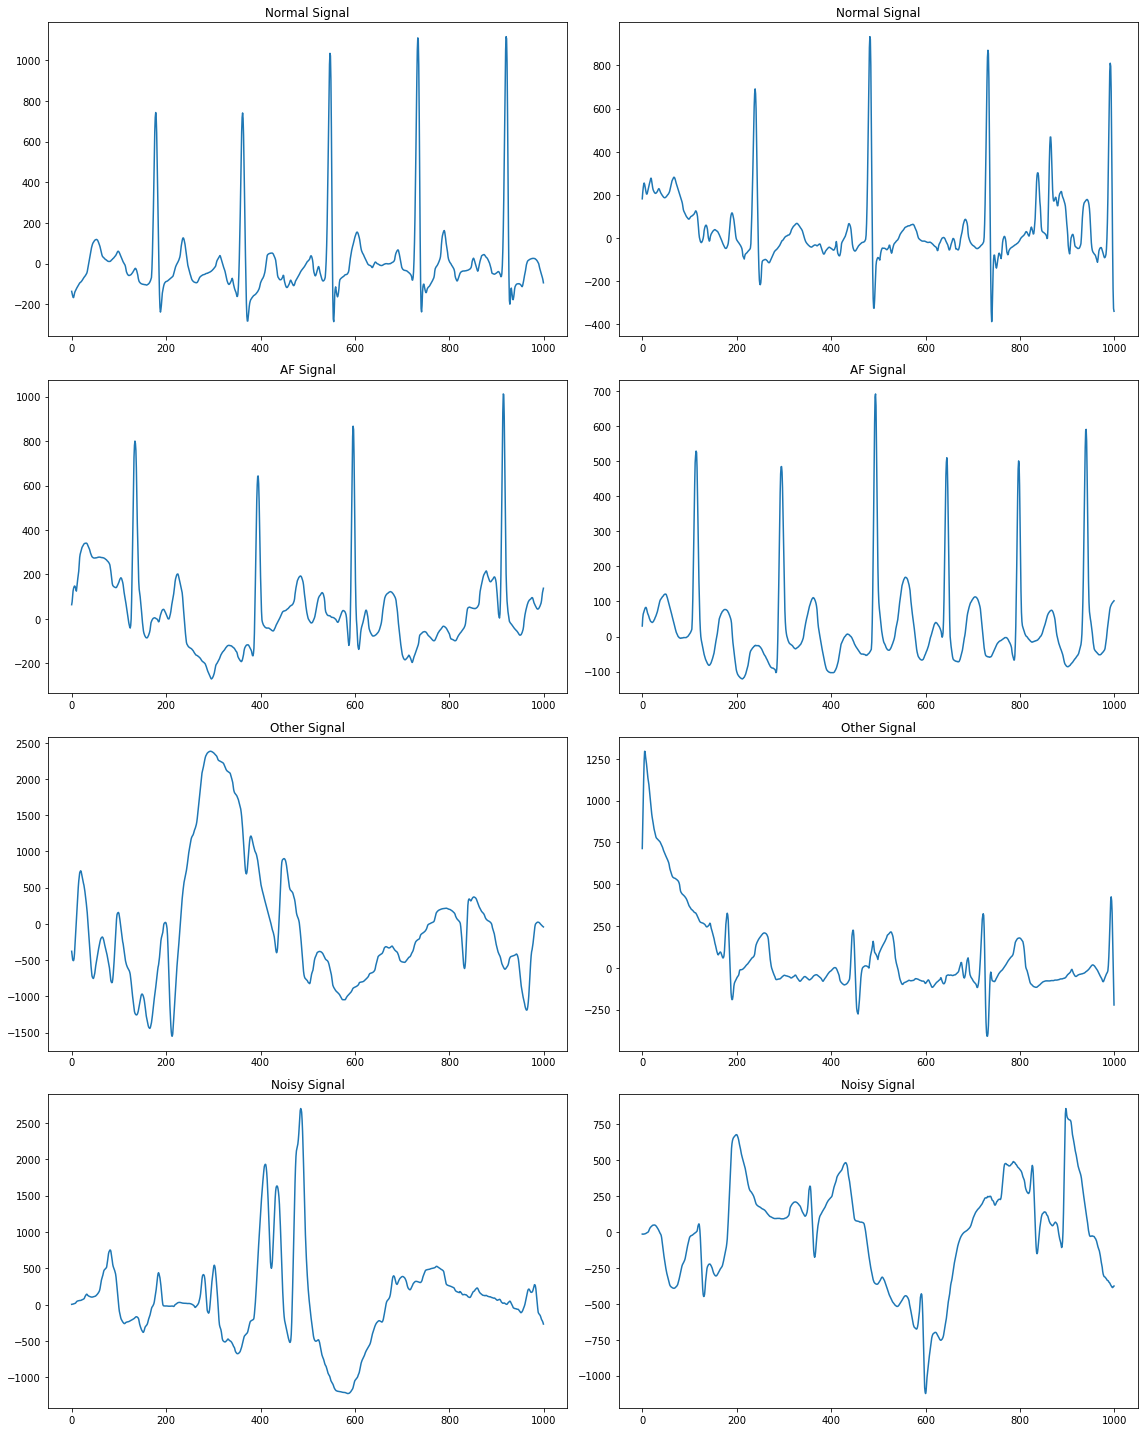

In [17]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, klass in enumerate(label_dict.keys()):
    class_signals = [signal for signal, label in zip(signals, labels.iloc[:, 0]) if label == klass]
    # 2 random samples from each class
    random_signals = random.sample(class_signals, 2)
    for j, signal in enumerate(random_signals):
        axes[2*i+j].plot(signal[:1000])
        axes[2*i+j].set_title(f"{label_dict[klass]} Signal")

plt.tight_layout()
plt.show()

In [18]:
ecg_signals_df = pd.DataFrame({'signal': signals, 'label': labels.iloc[:, 0]})

class_stats = {}
for label, group in ecg_signals_df.groupby('label'):
    all_signals = np.concatenate(group['signal'].values)
    class_stats[label] = {
        'mean_value': np.mean(all_signals),
        'std': np.std(all_signals),
        'min_value': np.min(all_signals),
        'max_value': np.max(all_signals),
    }

for klass, stats in class_stats.items():
    print(f"{label_dict[klass]} signals value statistics:")
    for key, value in stats.items():
        print(f"{key}: {value}")
    print()

Normal signals value statistics:
mean_value: 7.776893132948782
std: 228.91782256108615
min_value: -10636
max_value: 8318

AF signals value statistics:
mean_value: 8.05483615323212
std: 201.11813186742305
min_value: -6323
max_value: 6342

Other signals value statistics:
mean_value: 6.634971792665984
std: 234.0026985713716
min_value: -7360
max_value: 8257

Noisy signals value statistics:
mean_value: 5.312112830608064
std: 502.3936728696453
min_value: -7030
max_value: 7440



##### Insights
- Noisy signals are shorter on average, so unusually short segments might indicate noise. But overall, length alone won’t robustly separate classes. They also have a much higher standard deviation, indicating more volatility. This is a very strong cue for identifying noisy signals.

- Signals are for sure not representative enough. Some of "normal" ECG signals are not normal for example. The figure below and the plot of normal signals above are not always similar. 


### Visual Patterns / Rhythm

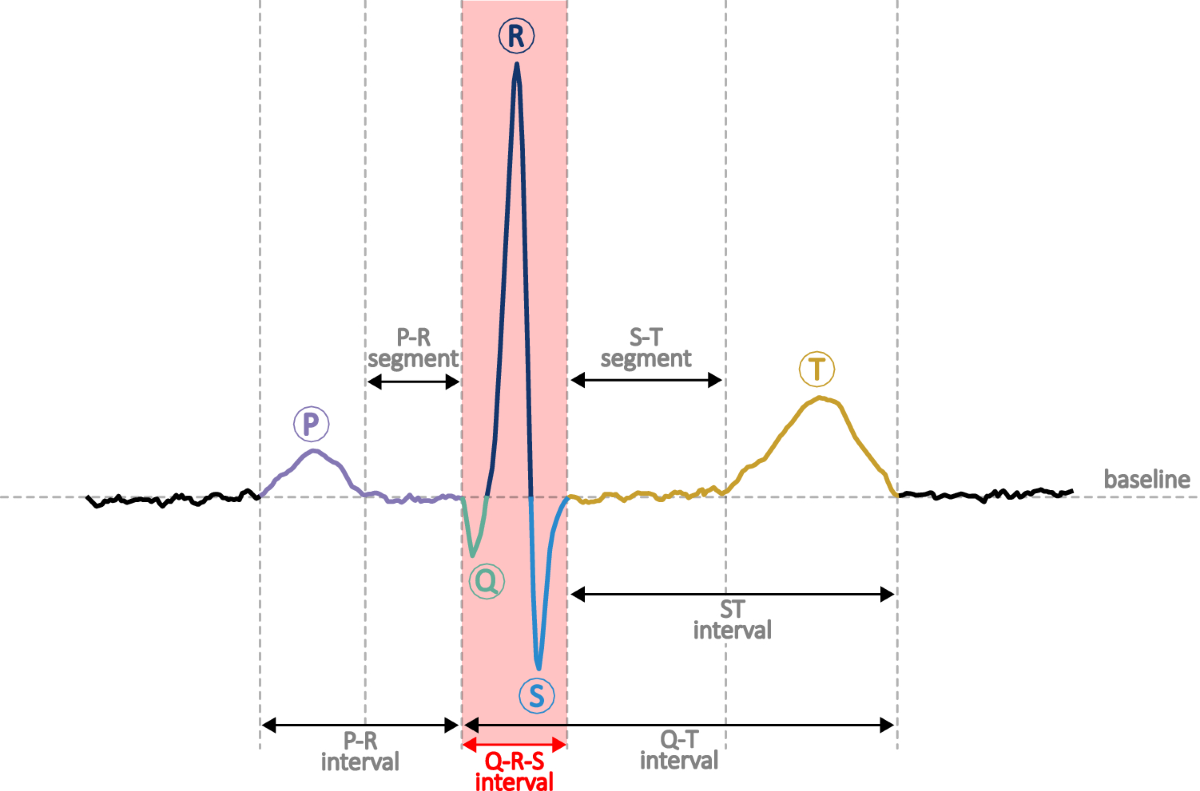


The QRS interval is a distinct part of the ECG waveform that reflects the electrical activity of the ventricles (the main chambers of the heart) as they contract.

The R wave is one of the deflections within the QRS complex. It's the positive (upward) deflection, and it's typically the largest wave in the QRS.

The R peak is simply the highest point of the R wave within the QRS interval.

- Heart Rate Estimate
    -  Count R-peaks, divide by duration in minutes. Get the statistics of this value for each class
- RR Interval Variation
    - Compute the standard deviation of RR intervals over the signal.
   

In [32]:
from scipy.signal import find_peaks # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
from collections import defaultdict # https://docs.python.org/3/library/collections.html#defaultdict-objects

SAMPLING_RATE = 300 # 300 Hz information was given in the task

stats_by_class = defaultdict(list)

for idx, row in ecg_signals_df.iterrows():
    signal = row['signal']
    label = row['label']
    
    # A useful condition for periodic signals can be given with the distance argument.
    # In this case, we can select the positions of QRS complexes within ECG by demanding a distance of at least 150 samples.
    peaks, _ = find_peaks(signal, distance = SAMPLING_RATE * 0.5)
    duration_seconds = len(signal) / SAMPLING_RATE
    heart_rate_bpm = len(peaks) / (duration_seconds / 60)
    
    rr_intervals = np.diff(peaks) / SAMPLING_RATE 
    rr_std_ms = np.std(rr_intervals * 1000) # calculating std in ms for clear values
    
    stats_by_class[label].append((heart_rate_bpm, rr_std_ms))
    
for label in sorted(stats_by_class.keys()):
    data = np.array(stats_by_class[label])
    heart_rates = data[:, 0]
    rr_stds = data[:, 1]

    print(f"\nClass {label_dict[label]}:")
    print(f"  Heart Rate (bpm): mean={heart_rates.mean():.2f}, std={heart_rates.std():.2f}, min={heart_rates.min():.2f}, max={heart_rates.max():.2f}")
    print(f"  RR Std Dev (ms): mean={rr_stds.mean():.2f}, std={rr_stds.std():.2f}, min={rr_stds.min():.2f}, max={rr_stds.max():.2f}")


Class Normal:
  Heart Rate (bpm): mean=78.75, std=8.89, min=60.00, max=106.00
  RR Std Dev (ms): mean=105.06, std=68.17, min=2.40, max=283.32

Class AF:
  Heart Rate (bpm): mean=84.45, std=5.66, min=64.00, max=104.00
  RR Std Dev (ms): mean=142.57, std=33.72, min=19.65, max=265.88

Class Other:
  Heart Rate (bpm): mean=82.88, std=10.58, min=60.00, max=118.00
  RR Std Dev (ms): mean=122.54, std=59.96, min=2.34, max=298.27

Class Noisy:
  Heart Rate (bpm): mean=83.59, std=6.46, min=66.00, max=111.04
  RR Std Dev (ms): mean=150.35, std=32.77, min=27.03, max=227.28


##### Insights

- Heart Rate Estimate
    - There is no striking result here. The values may not be representative for real life values.
- RR Internal Variation
    - AF and Noisy signals have high HRV (Heart Rate Variability) however,

    - AF's HRV is physiological (due to irregular rhythm)

    - Noisy's HRV is likely artifactual (due to poor signal quality)

    - Normal signals tend to cluster around lower HRV, though with some exceptions.

    - RR std dev can be a key feature for distinguishing AF vs Normal
    
    - High HRV + signal quality metric (e.g. signal length) can help distancing AF from Noisy

##### Split Strategy

- Compute RR std for each signal.

- Bin samples in that class into quantiles of RR std.

- From each bin, sample proportionally into the validation set (15%).

- Combine validation samples from all classes and bins.

- Ensure no overlap between training and validation sets.



In [40]:
from sklearn.model_selection import train_test_split

def compute_rr_std(signal, fs=SAMPLING_RATE):
    peaks, _ = find_peaks(signal, distance=fs*0.5)
    rr_intervals = np.diff(peaks) * 1000 / fs  # in ms
    return np.std(rr_intervals)

ecg_signals_df['rr_std'] = ecg_signals_df['signal'].apply(lambda x: compute_rr_std(x))

val_indices = []

for label in ecg_signals_df['label'].unique():
    class_df = ecg_signals_df[ecg_signals_df['label'] == label].copy()
    class_df.loc[:, 'rr_bin'] = pd.qcut(class_df['rr_std'], q=4, labels=False, duplicates='drop')
    
    for b in class_df['rr_bin'].unique():
        bin_df = class_df[class_df['rr_bin'] == b]
        val_bin_indices = bin_df.sample(frac=0.15, random_state=42).index
        val_indices.extend(val_bin_indices)

val_df = ecg_signals_df.loc[val_indices]
train_df = ecg_signals_df.drop(index=val_indices)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 5252, Validation samples: 927


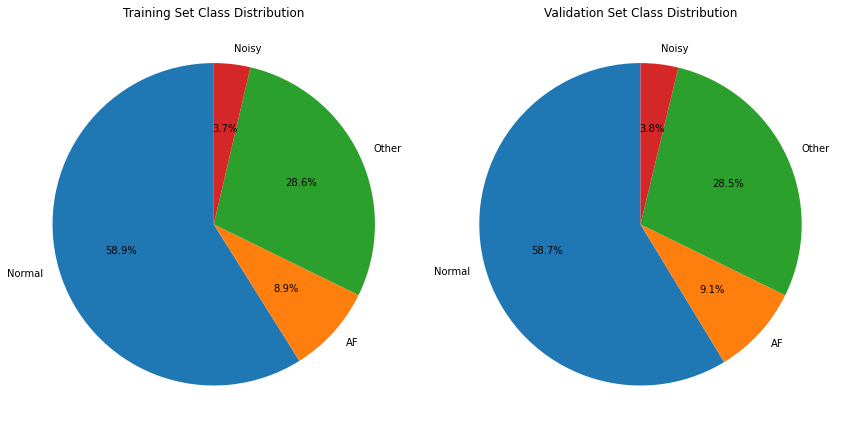

In [49]:
train_counts = train_df['label'].value_counts().sort_index()
val_counts = val_df['label'].value_counts().sort_index()

train_labels = [label_dict[i] for i in train_counts.index]
val_labels = [label_dict[i] for i in val_counts.index]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Set Class Distribution')

axs[1].pie(val_counts, labels=val_labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Validation Set Class Distribution')

plt.tight_layout()
plt.show()

Our strategy let us creating two sets (train and validation) that has similar class distribution. Also every classes in both sets include various number of samples that have different values for standard deviation of RR interval, also called Hearth Rate Variability.